In [1]:
############# INSTALL PACKAGES ###################################

# We use a package that might be new to some of you, called "INLA" 
# This package helps implement Bayesian methods and helps make some of our steps fast/easy to implement

############# OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

# install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
# install.packages("fmesher", dependencies = TRUE)
# install.packages("MatrixModels", type = "source")
# install.packages("exactextractr")
# install.packages("sn" ,dependencies = TRUE)
# packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields","png")
# package.check <- lapply(packages, FUN = function(x) {
#     if (!require(x, character.only = TRUE)) {
#         install.packages(x, dependencies = TRUE)
#         library(x, character.only = TRUE, quietly=TRUE)
#     }
# })
# Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

# ##### THE FOLLOWING COMMANDS ARE FOR THE INSTALLATION OF PACKAGES ON LINUX (NASA MAAP) #####
# ##### CONDA-FORGE YOUR WAY THROUGH DEPENDENCIES THAT DID NOT INSTALL ##########

# conda install conda-forge::r-fmesher
# conda install conda-forge::r-exactextractr
# conda install conda-forge::r-sn
# conda install conda-forge::r-inlabru
# conda install conda-forge::r-fields

In [33]:
############## LOAD PACKAGES ###########

library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)
library("jpeg")

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
library(exactextractr)

library(ggplot2)
library(viridis)
library(sn)

## MAKING PREDICTIONS USING OUR MODEL RESULTS ########################################

Once we have settled on the model to be used, our next task to is use the model to make predictions of AGBD in at any location or over any arbitrary area. 

In the following cells, we demonstrate numerous such applications. At the start, we read our saved model, recreate our mesh (in case it was not already saved) 
and then begin the predictions. 


In [34]:
######################### READ THE SAVED MODEL ######################

#### LOAD THE DATA USED TO MAKE THE MODEL ######
mexico = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON1_DISS.gpkg", quiet = TRUE) %>% st_union() %>% st_transform(crs = 6933) # Provided by CONAFOR and converted to a projected CRS so we can work in units of meters
DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/NFI_CCI_GEDIheights.csv") #Read the saved data
cci.plot <- DATA$cci.plot
hei.plot <- DATA$hei.plot
loc.plot <- data.frame(matrix(ncol = 2, nrow = length(hei.plot))) # Just create empty list to populated with saved NFI xy locations
loc.plot[,1] <- DATA$X
loc.plot[,2] <- DATA$X.1
agbd.plot <- sqrt(DATA$agbd.plot)
loc.plot <- data.matrix(loc.plot)

###### REMAKE THE MESH IN CASE IT IS NOT STORED IN MEMORY ######
max.edge = 10*10^3
mexico.buffer = st_buffer(mexico, dist = max.edge*5) # We also make a 5 km buffer around Mexico to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(mexico, "Spatial"), as(mexico.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot)

##### LOAD THE MODEL RESULTS ####
load("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/INLA_model_fit_v2.RData")

#### LOAD AN URBAN MASK AND PROBABILITY OF FOREST MASK FOR MEXICO ####
URBAN = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/MGN2020_INEGI_Urban_Mex_mask_DISS.gpkg",quiet=TRUE) #https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=889463807469
FNF = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/All_Products_Comp_Over30_Binary_6933.tif") #https://daac.ornl.gov/CMS/guides/SatelliteDerived_Forest_Mexico.html

Cannot preload entire working area of 9239096555 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 730870672 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Saving 6.67 x 6.67 in image


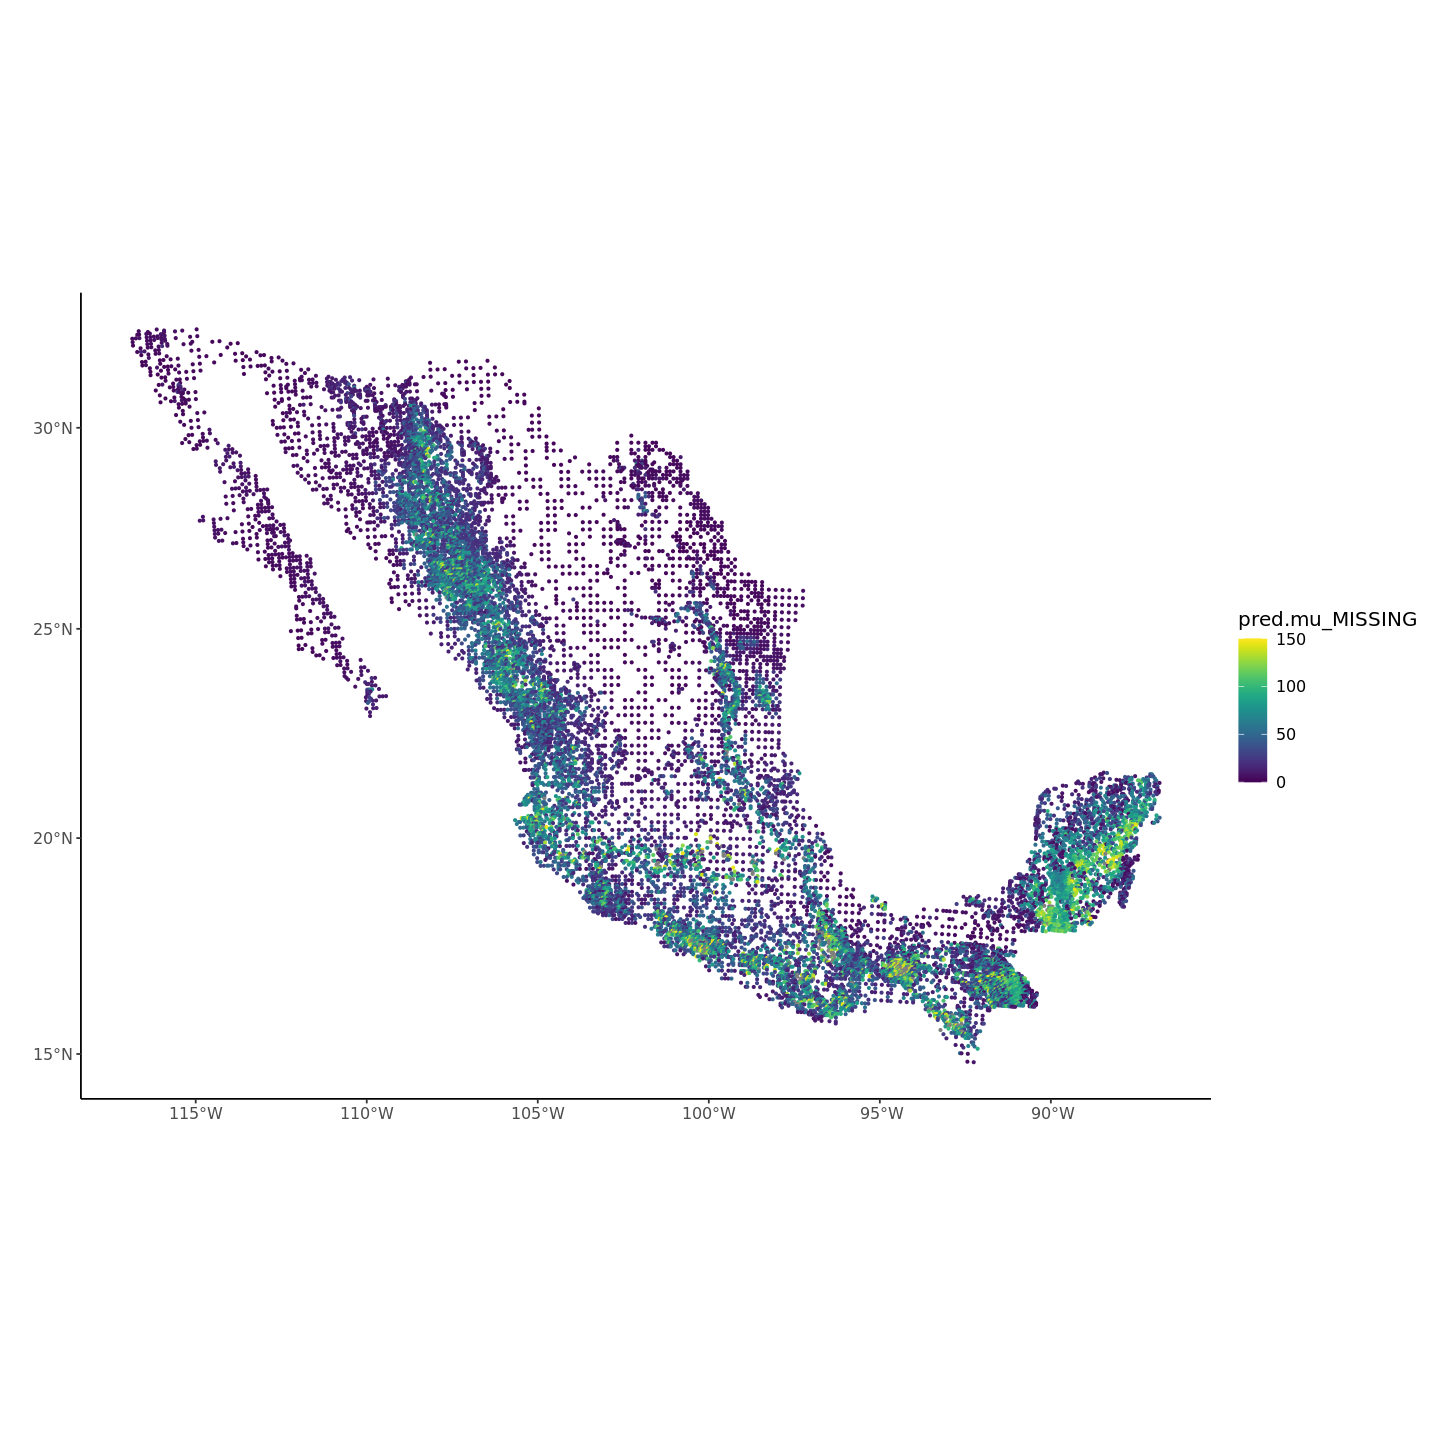

Saving 6.67 x 6.67 in image


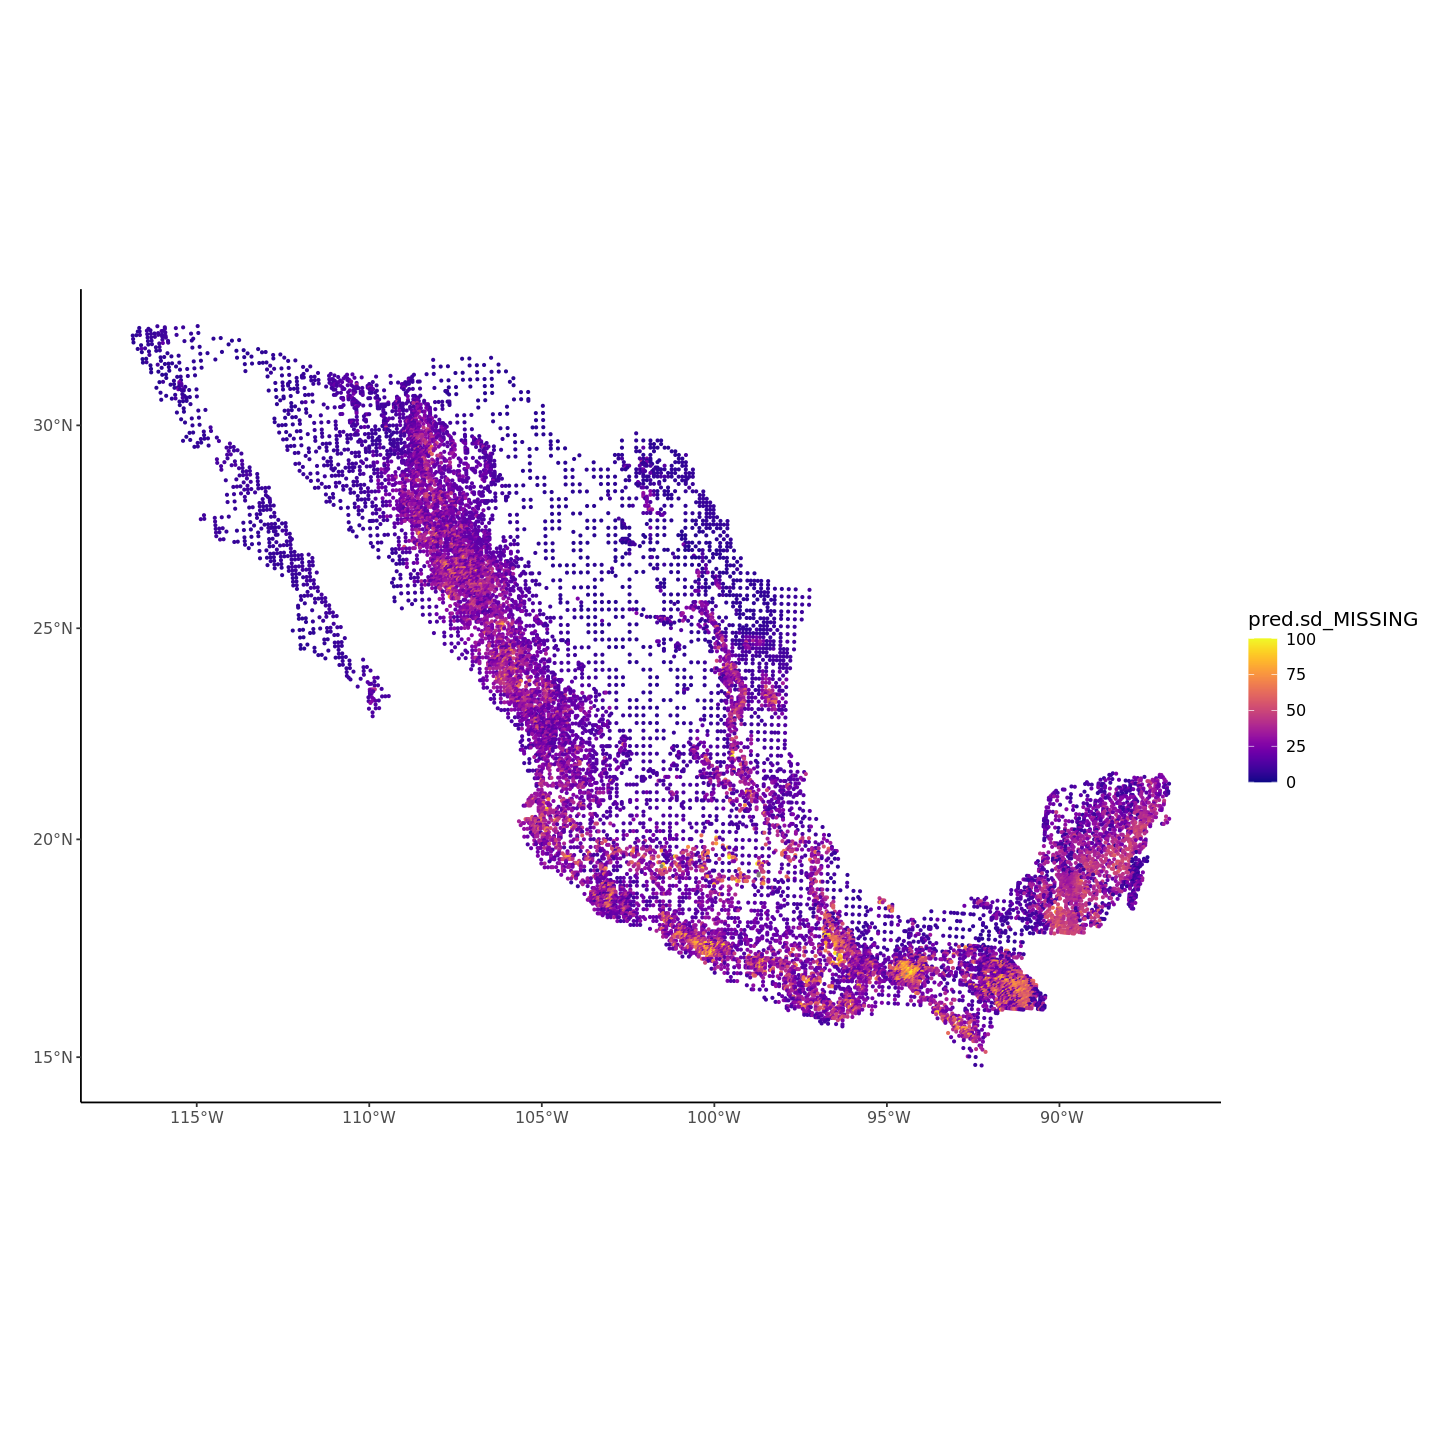

In [37]:
########################## GAP-FILL MEXICO's LOCATIONS WHERE MEXICO'S THIRD NFI IS INCOMPLETE ##################

# Mexico's third NFI cycle was incomplete due to several accessibility and funding issues. 
# We know the locations at which plots should have been measured, and can use our model to predict AGBD at those locations

options(repr.plot.width=12, repr.plot.height=12)
hei.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/GLAD_FH_mexico_UINT16_C_6399.tif")### Read GLAD FOREST HEIGHT raster, already in projected CRS
cci.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/cci_mexico_6933.tif") ### Read CCI raster, already in projected CRS

# Read the locations where plots were not measured
MISSING_plot_WGS84 <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/MISSING_Coordenades_INFyS_2y3_conafor.gpkg", quiet = TRUE)
MISSING.loc.plot.WGS84 <- st_coordinates(MISSING_plot_WGS84)  ### get the plot locations in WGS84
MISSING.plot = MISSING_plot_WGS84 %>% st_transform("epsg:6933") ### convert them to a projected CRS
MISSING.loc.plot = st_coordinates(MISSING.plot) ### save the plot location xy coordinates in projected CRS

# # We'll need our covariate values at the grid locations
hei.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/GLAD_FH_mexico_UINT16_C_6399.tif")### Read GLAD FOREST HEIGHT raster, already in projected CRS
hei.pred = exactextractr::exact_extract(hei.rast, st_buffer(MISSING.plot,56.42), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel

cci.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/cci_mexico_6933.tif") ### Read CCI raster, already in projected CRS
cci.pred = exactextractr::exact_extract(cci.rast, st_buffer(MISSING.plot,56.42), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel

samples = inla.posterior.sample(n = 1000, result = model_fit_v2) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = MISSING.loc.plot) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    cci.pred*cci + 
    hei.pred*hei +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k] +
    Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# # Generate prediction samples
pred.samples = (inla.posterior.sample.eval(fun = pred_fun, samples = samples))
pred.samples[pred.samples < 0] = 0

# # Model expectations and SD's at the grid locations
pred.mu_MISSING = Matrix::rowMeans(pred.samples^2) # Mean AGBD values at each grid center
pred.sd_MISSING = apply(pred.samples^2, 1, sd) # SD of AGBD at each grid center

######## Save the pred.samples output, because it will be needed for stratum-wise or country-wide AGBD estimates ############
MISSING_NFI.pred.samples = cbind(pred.samples^2,MISSING.loc.plot[,1],MISSING.loc.plot[,2])

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = MISSING.loc.plot[,1], y = MISSING.loc.plot[,2], col = pred.mu_MISSING),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 150)) + xlab("") + ylab("") + theme(text = element_text(size = 12),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
ggsave("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/MISSING_NFI_MEAN.png",plot = last_plot(),scale = 1,dpi = 400)

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = MISSING.loc.plot[,1], y = MISSING.loc.plot[,2], col = pred.sd_MISSING),size=0.5) +  # make a map to see plot locations and SD of AGBD values at each location
           scale_color_viridis(option="plasma",limits = c(0, 100)) +     xlab("") + ylab("") + theme(text = element_text(size = 12),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
ggsave("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/MISSING_NFI_SD.png",plot = last_plot(),scale = 1,dpi = 400)

## USE THE GMB TO PREDICT AGBD IN ALL TERRESTRIAL ECOLOGICAL STRATA OF MEXICO 

Saving 6.67 x 6.67 in image


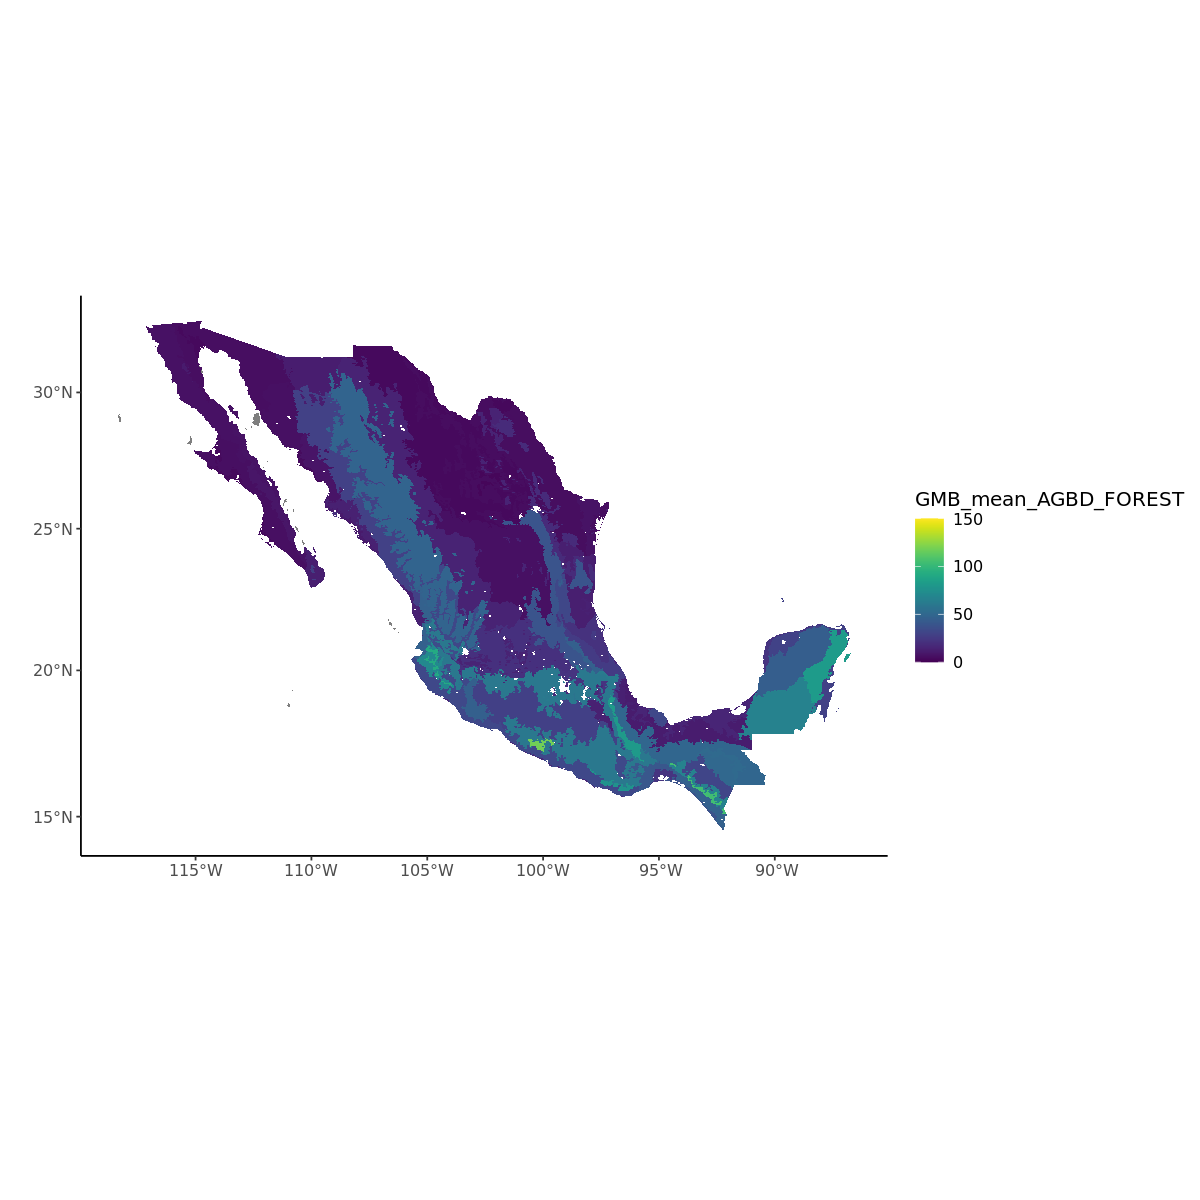

Saving 6.67 x 6.67 in image


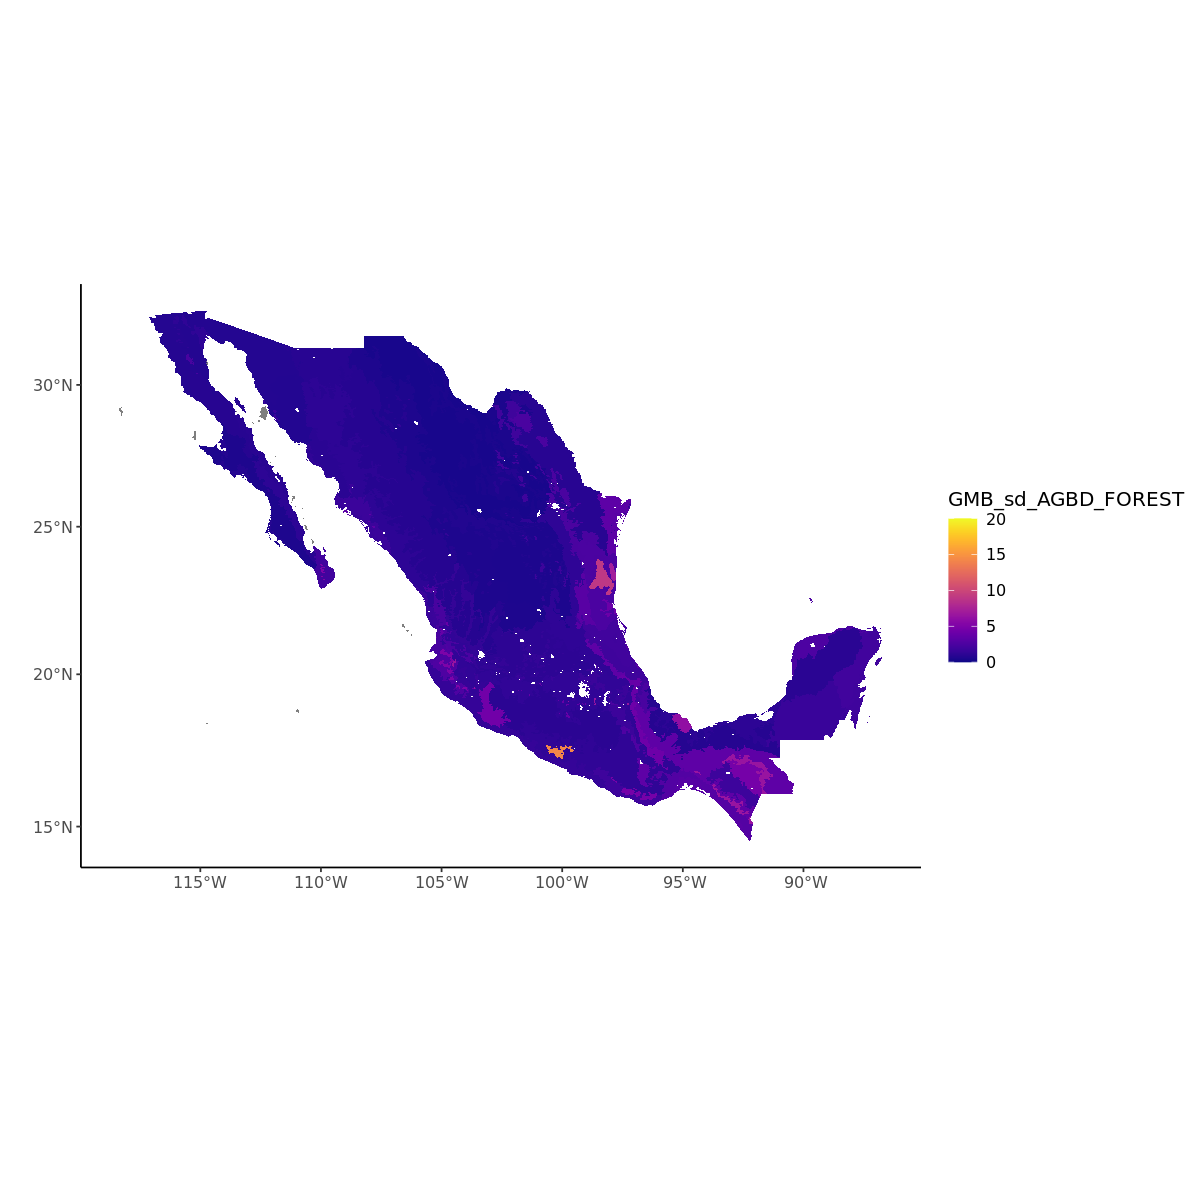

Saving 6.67 x 6.67 in image


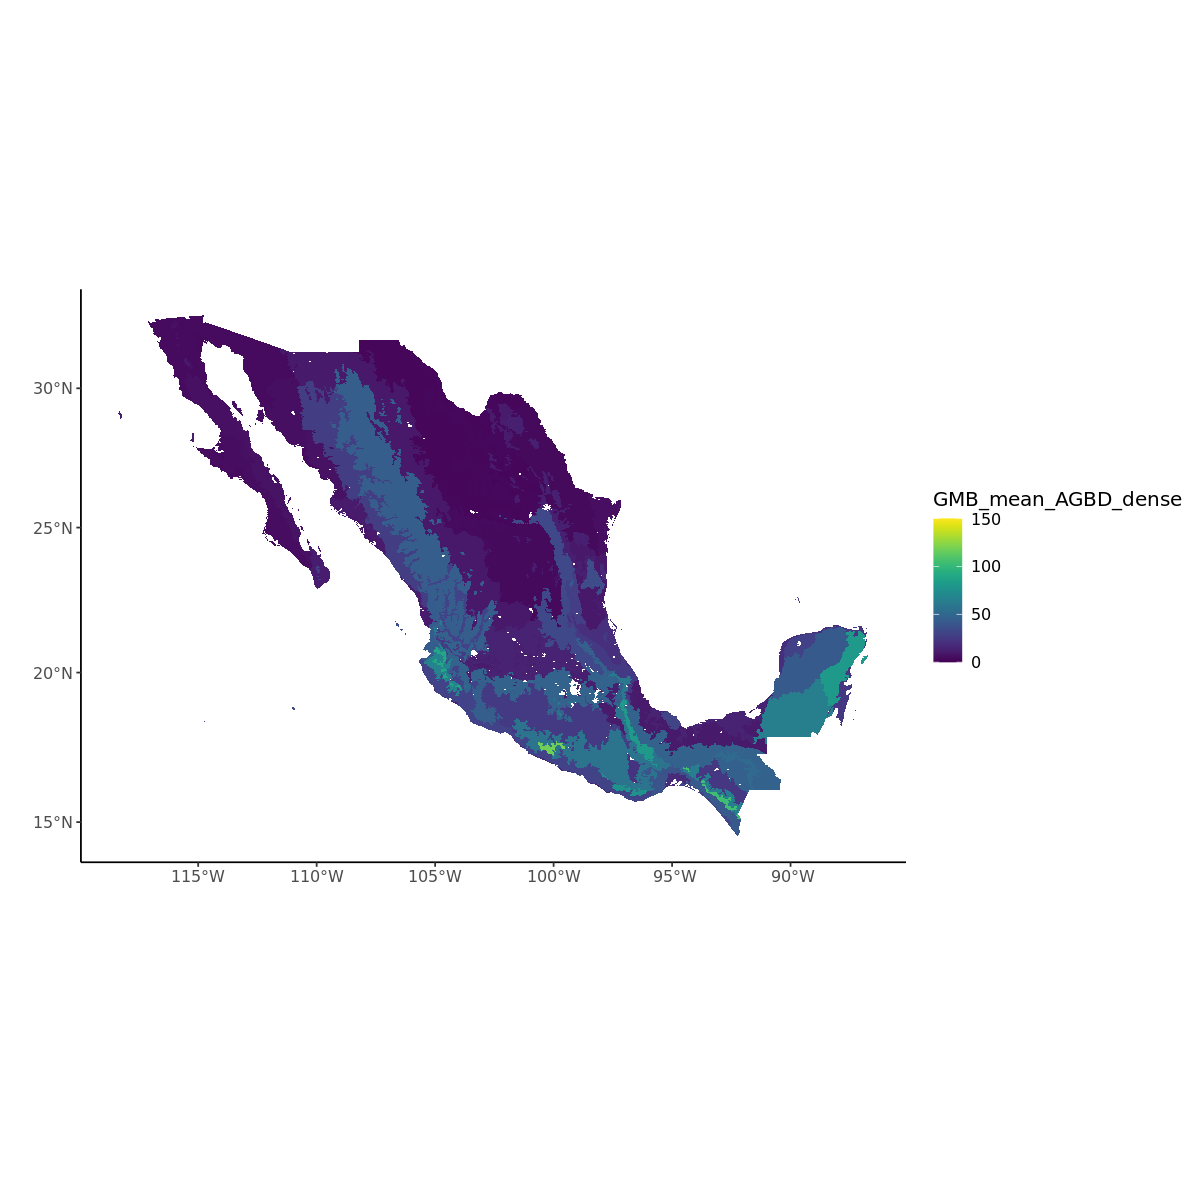

Saving 6.67 x 6.67 in image


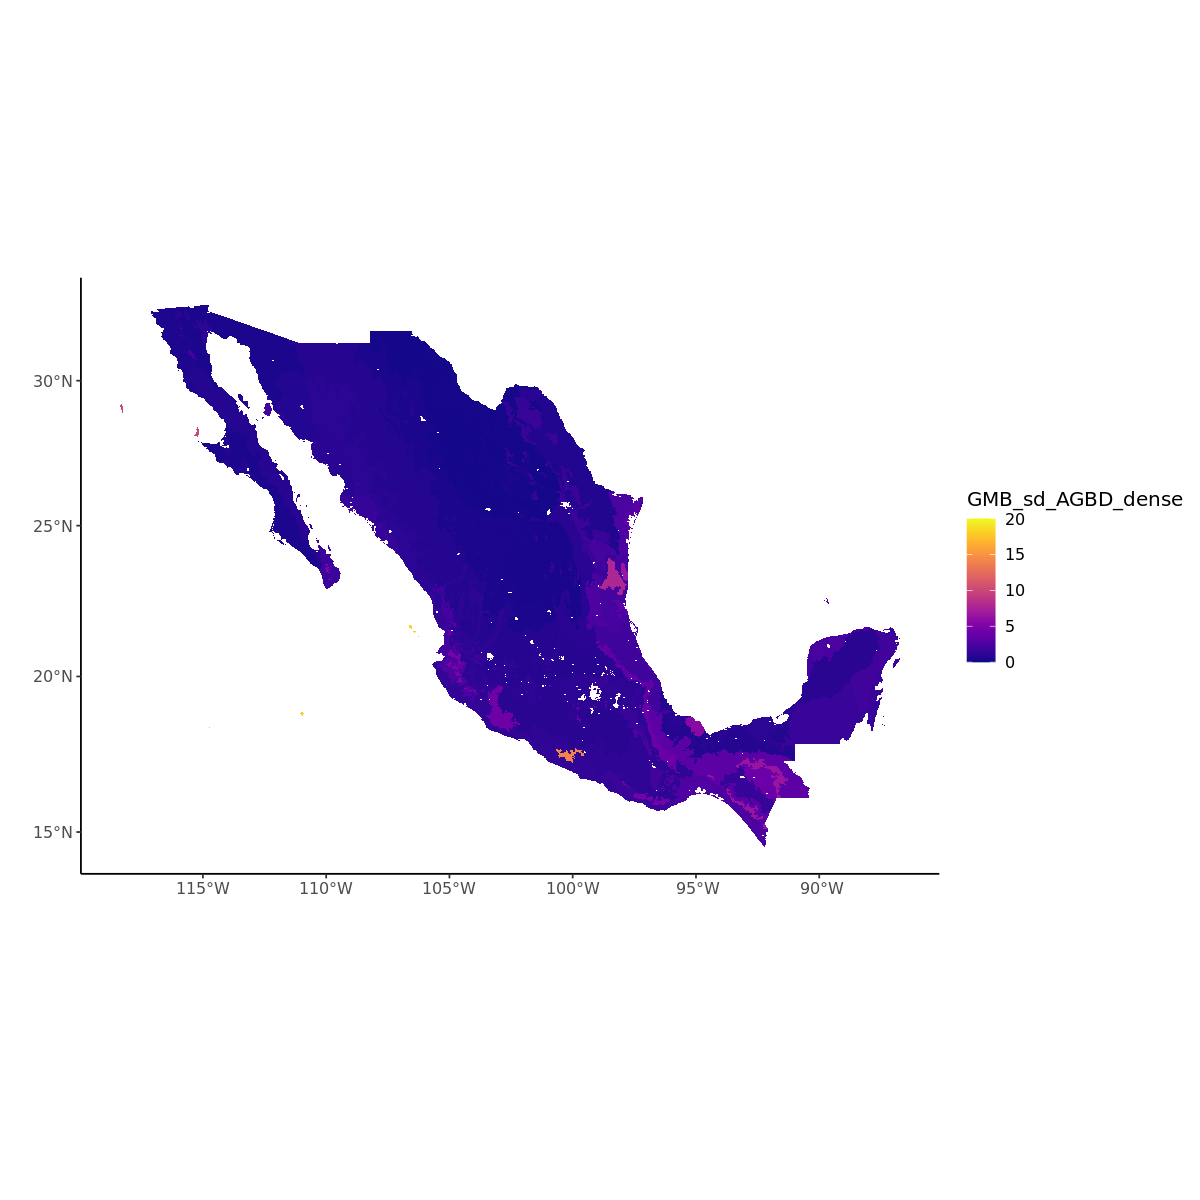

In [15]:
### FIRST, READ THE MEXICAN DESECON4 (terrestrial ecological strata) POLYGONS
options(repr.plot.width=10, repr.plot.height=10)
options(warn = -1) # supress warnings

SIZE = c(20000,15000,10000,5000,2500,1000,500)

samples = inla.posterior.sample(n = 250, result = model_fit_v2) # draw samples from our posterior distribution

for (SIZ in SIZE){
    # Create empty fields, which we will populate with our predictions in a dense grid created by us inside each feature
    # This dense grid, for example, represents a very dense NFI sampling design.
    DESECON[,"GMB_mean_AGBD_dense"] = NA
    DESECON[,"GMB_sd_AGBD_dense"] = NA
    DESECON[,"GMB_mean_AGBD_FOREST"] = NA
    DESECON[,"GMB_sd_AGBD_FOREST"] = NA

    for (f in (1:nrow(DESECON)))  {

        DESECON_ID = DESECON[f,]$DESECON4

        # Create the grid inside our patch of land, because we will predict AGBD at each grid center!
        grid_to_predict = st_make_grid(DESECON[f,], cellsize = c(SIZ,SIZ), what = "centers") %>% st_as_sf() %>% st_filter(DESECON[f,]) # Create a 1 km x 1 km grid 
        grid = grid_to_predict %>% st_coordinates()
        
        # We'll need our covariate values at the grid locations
        cci.pred = extract(cci.rast, grid)[,1]
        hei.pred = extract(hei.rast, grid)[,1]
        fnf.pred = extract(FNF, grid)[,1]
        
        # This section is optional. We choose to select only vegetated areas inside each strata using forest likelihood mask of Mexico
        fnf.sums = fnf.pred
        if (length(fnf.pred)>0){
        for (f in 1:length(fnf.pred)){
            a = as.integer(c(strsplit(as.character(fnf.pred[f]),split="")[[1]]))
            if ((length(sum(a))>=1) & (!is.na(sum(a)))){
            if (sum(a) >= 1){fnf.sums[f] <- 1}
            if (sum(a) < 1){fnf.sums[f] <- 0}}
            if ((length(sum(a))<1) | (is.na(sum(a)))) {fnf.sums[f] <- 0}
        }}
        
        if (length(cci.pred) > 0 && length(hei.pred) > 0){
        A.pred = inla.spde.make.A(mesh = mesh, loc = grid) # remake our projector matrix for the grid centers
        pred_fun = function(...){
          drop(intercept + 
            cci.pred*cci + 
            hei.pred*hei +
            A.pred%*%alpha.spat[1:k] +   
            Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k] +
            Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:k]) +
            rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
        }

        # Generate prediction samples
        pred.samples = (inla.posterior.sample.eval(fun = pred_fun, samples = samples))
        pred.samples[pred.samples < 0] = 0

        # Model expectations and SD's at the grid locations
        pred.mu_dense = Matrix::rowMeans(pred.samples^2, na.rm = TRUE) # Mean AGBD values at each grid center
        pred.sd_dense = apply(pred.samples^2, 1, sd, na.rm = TRUE) # SD of AGBD at each grid center
        
        DESECON$GMB_mean_AGBD_dense[DESECON$DESECON4 == DESECON_ID] <- round(mean(pred.mu_dense,na.rm=TRUE),digits=2)
        DESECON$GMB_sd_AGBD_dense[DESECON$DESECON4 == DESECON_ID] <- round(sd(colMeans(pred.samples^2, na.rm = T),na.rm=TRUE),digits=2)
                        
        # Remove grid points that a majority of layers say have (non) forest
        fnf.sums[fnf.sums == 0] = NA
        pred.samples = fnf.sums*pred.samples # forces the non-forest areas to be set to NA 
        
        # Model expectations and SD's at the grid locations
        pred.mu_dense = Matrix::rowMeans(pred.samples^2, na.rm = TRUE) # Mean AGBD values at each grid center
        pred.sd_dense = apply(pred.samples^2, 1, sd, na.rm = TRUE) # SD of AGBD at each grid center

        DESECON$GMB_mean_AGBD_FOREST[DESECON$DESECON4 == DESECON_ID] <- round(mean(pred.mu_dense,na.rm=TRUE),digits=2)
        DESECON$GMB_sd_AGBD_FOREST[DESECON$DESECON4 == DESECON_ID] <- round(sd(colMeans(pred.samples^2, na.rm = T),na.rm=TRUE),digits=2)

        #### SAVE OUR RESULTS 
        write.csv(st_drop_geometry(DESECON),paste0("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON4_FNF_",toString(SIZ),"_predictions.csv"))
}}}

END <- read.csv('/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON4_FNF_500_predictions.csv')
DESECON[,"GMB_mean_AGBD_dense"] = END[,"GMB_mean_AGBD_dense"] 
DESECON[,"GMB_sd_AGBD_dense"] = END[,"GMB_sd_AGBD_dense"]
DESECON[,"GMB_mean_AGBD_FOREST"] = END[,"GMB_mean_AGBD_FOREST"] 
DESECON[,"GMB_sd_AGBD_FOREST"] = END[,"GMB_sd_AGBD_FOREST"]

############ PLOT ONLY "FOREST" AREA INSIDE DESECON ################
options(repr.plot.width=10, repr.plot.height=10)
ggplot(DESECON) + geom_sf(aes(fill = GMB_mean_AGBD_FOREST), colour = "black", size = 0.5, lwd = 0) + scale_fill_viridis(limits=c(0,150)) + 
    xlab("") + ylab("") + theme(text = element_text(size = 12),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
ggsave("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON_MEAN_FNF.png",plot = last_plot(),scale = 1,dpi = 400)
ggplot(DESECON) + geom_sf(aes(fill = GMB_sd_AGBD_FOREST), colour = "black", size = 0.5, lwd = 0) + scale_fill_viridis(option="plasma",limits=c(0,20)) + 
    xlab("") + ylab("") + theme(text = element_text(size = 12),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
ggsave("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON_SD_FNF.png",plot = last_plot(),scale = 1,dpi = 400)

############ PLOT ALL AREA INSIDE DESECON ################
options(repr.plot.width=10, repr.plot.height=10)
ggplot(DESECON) + geom_sf(aes(fill = GMB_mean_AGBD_dense), colour = "black", size = 0.5, lwd = 0) + scale_fill_viridis(limits=c(0,150)) + 
    xlab("") + ylab("") + theme(text = element_text(size = 12),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
ggsave("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON_MEAN.png",plot = last_plot(),scale = 1,dpi = 400)
ggplot(DESECON) + geom_sf(aes(fill = GMB_sd_AGBD_dense), colour = "black", size = 0.5, lwd = 0) + scale_fill_viridis(option="plasma",limits=c(0,20)) + 
    xlab("") + ylab("") + theme(text = element_text(size = 12),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
ggsave("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON_SD.png",plot = last_plot(),scale = 1,dpi = 400)

Saving 6.67 x 6.67 in image


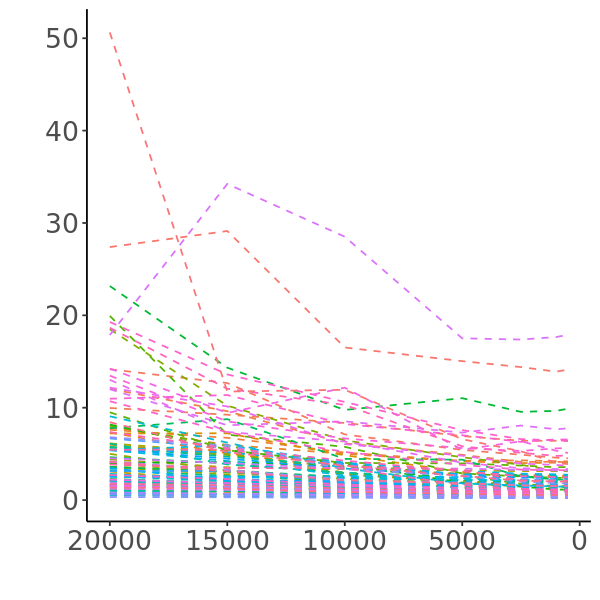

Saving 6.67 x 6.67 in image


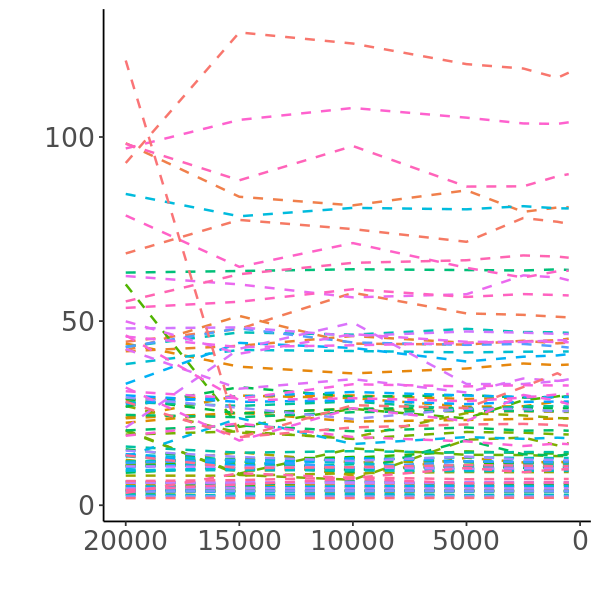

Saving 6.67 x 6.67 in image


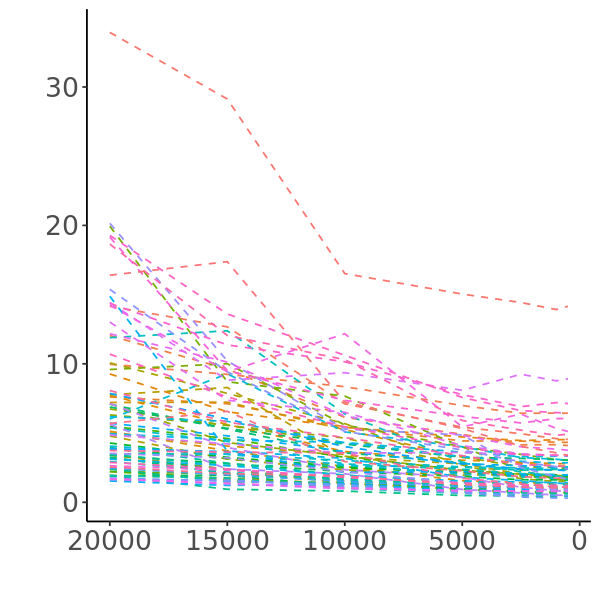

Saving 6.67 x 6.67 in image


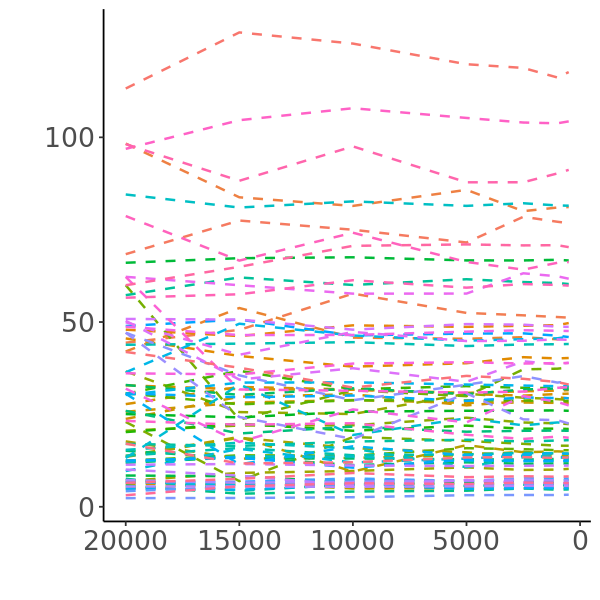

In [12]:
################## GAIN IN PRECISION WITH INCREASING SAMPLING SIZE ############

options(repr.plot.width=5, repr.plot.height=5)
Predictions <- list.files(path = "/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO", pattern = c("DESECON4_FNF_","_predictions.csv"),full.names = TRUE)

# Plot full area inside each DESECON

for (n in 1:length(Predictions)) {
    DIST <- (unlist(strsplit(basename(Predictions),split = "_")[n])[3])
    Data <- read.csv(Predictions[n])
    Data <- Data[c("AREA", "DESECON4", "GMB_mean_AGBD_dense", "GMB_sd_AGBD_dense")]
    Data["DIST"] <- as.integer(DIST)
    if (n==1){PREDS <- Data}
    if (n>1){PREDS <- rbind(PREDS,Data)}
}

PREDS_AREA1 <- PREDS[(PREDS$DESECON != "Cuerpo de Agua"),]#(PREDS$AREA > 1000000) && 
PREDS_AREA1 <- PREDS_AREA1 %>% group_by(DESECON4) %>% filter(!any(is.na(GMB_sd_AGBD_dense)))
ggplot(PREDS_AREA1,aes(DIST, GMB_sd_AGBD_dense)) + 
    geom_line(aes(col = factor(DESECON4)),linetype = "dashed", size = 0.5) +
    scale_x_reverse() +
    xlab("") + 
    ylab("") + 
    # ylim(0,15)+
    theme(text = element_text(size = 20),legend.position="none",panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
ggsave("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON_MEAN_TREND.png",plot = last_plot(),scale = 1,dpi = 400)

ggplot(PREDS_AREA1,aes(DIST, GMB_mean_AGBD_dense)) + 
    geom_line(aes(col = factor(DESECON4)),linetype = "dashed", size = 0.7) +
    scale_x_reverse() +
    xlab("") + 
    ylab("") + 
    # ylim(0,90)+
    theme(text = element_text(size = 20),legend.position="none",panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
ggsave("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON_SD_TREND.png",plot = last_plot(),scale = 1,dpi = 400)

# Plot on forested area inside each DESECON

for (n in 1:length(Predictions)) {
    DIST <- (unlist(strsplit(basename(Predictions),split = "_")[n])[3])
    Data <- read.csv(Predictions[n])
    Data <- Data[c("AREA", "DESECON4", "GMB_mean_AGBD_FOREST", "GMB_sd_AGBD_FOREST")]
    Data["DIST"] <- as.integer(DIST)
    if (n==1){PREDS <- Data}
    if (n>1){PREDS <- rbind(PREDS,Data)}
}
PREDS_AREA1 <- PREDS[(PREDS$DESECON != "Cuerpo de Agua"),]
PREDS_AREA1 <- PREDS_AREA1 %>% group_by(DESECON4) %>% filter(!any(is.na(GMB_sd_AGBD_FOREST)))
ggplot(PREDS_AREA1,aes(DIST, GMB_sd_AGBD_FOREST)) + 
    geom_line(aes(col = factor(DESECON4)),linetype = "dashed", size = 0.5) +
    scale_x_reverse() +
    xlab("") + 
    ylab("") + 
    # ylim(0,15)+
    theme(text = element_text(size = 20),legend.position="none",panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
ggsave("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON_FNF_MEAN_TREND.png",plot = last_plot(),scale = 1,dpi = 400)

ggplot(PREDS_AREA1,aes(DIST, GMB_mean_AGBD_FOREST)) + 
    geom_line(aes(col = factor(DESECON4)),linetype = "dashed", size = 0.7) +
    scale_x_reverse() +
    xlab("") + 
    ylab("") + 
    # ylim(0,90)+
    theme(text = element_text(size = 20),legend.position="none",panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
ggsave("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON_FNF_SD_TREND.png",plot = last_plot(),scale = 1,dpi = 400)

In [39]:
# ### IN REPORTING TO THE UNFCCC, FOR EXAMPLE, MEXICO USES DESECON STRATA 1 OR 2. BELOW, WE USE THE SAME APPROACH TO MAKE PREDICTIONS OF AGBD IN THE THESE STRATA 

options(repr.plot.width=10, repr.plot.height=10)
options(warn = -1) # supress warnings

#### CONAFOR:Please apply the following urban mask: https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=889463807469

#### Choose either DESECON1 or DESECON2
DESECON = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON1_DISS.gpkg", quiet = TRUE) %>% st_transform(crs = 6933) # Provided by CONAFOR and converted to a projected CRS so we can work in units of meters
DESECON = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON2_DISS.gpkg", quiet = TRUE) %>% st_transform(crs = 6933) # Provided by CONAFOR and converted to a projected CRS so we can work in units of meters

#### Remove Urban areas 
DESECON <- st_difference(DESECON, URBAN) # Remove urban areas by cutting them out from the shapefile 

SIZE = c(10000)
samples = inla.posterior.sample(n = 250, result = model_fit_v2) # draw samples from our posterior distribution

for (SIZ in SIZE){
    # Create empty fields, which we will populate with our predictions in a dense grid created by us inside each feature
    # This dense grid, for example, represents a very dense NFI sampling design.
    DESECON[,"GMB_mean_AGBD_FOREST"] = NA
    DESECON[,"GMB_sd_AGBD_FOREST"] = NA

    for (f in (1:nrow(DESECON)))  {

        DESECON_ID = DESECON[f,]$DESECON4

        # Create the grid inside our patch of land, because we will predict AGBD at each grid center!
        grid_to_predict = st_make_grid(DESECON[f,], cellsize = c(SIZ,SIZ), what = "centers") %>% st_as_sf() %>% st_filter(DESECON[f,]) # Create a 1 km x 1 km grid 
        grid = grid_to_predict %>% st_coordinates()

        # We'll need our covariate values at the grid locations
        cci.pred = extract(cci.rast, grid)[,1]
        hei.pred = extract(hei.rast, grid)[,1]
        fnf.pred = extract(FNF, grid)[,1]
        
        fnf.sums = fnf.pred
        if (length(fnf.pred)>0){
        for (f in 1:length(fnf.pred)){
            a = as.integer(c(strsplit(as.character(fnf.pred[f]),split="")[[1]]))
            if ((length(sum(a))>=1) & (!is.na(sum(a)))){
            if (sum(a) >= 4){fnf.sums[f] <- 1}
            if (sum(a) < 4){fnf.sums[f] <- 0}}
            if ((length(sum(a))<1) | (is.na(sum(a)))) {fnf.sums[f] <- 0}
        }}

        if (length(cci.pred) > 0 && length(hei.pred) > 0){
        A.pred = inla.spde.make.A(mesh = mesh, loc = grid) # remake our projector matrix for the grid centers
        pred_fun = function(...){
          drop(intercept + 
            cci.pred*cci + 
            hei.pred*hei +
            A.pred%*%alpha.spat[1:k] +   
            Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k] +
            Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:k]) +
            rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
        }

        # Generate prediction samples
        pred.samples = (inla.posterior.sample.eval(fun = pred_fun, samples = samples))
        pred.samples[pred.samples < 0] = 0

        # Remove grid points that a majority of layers say have (non) forest
        fnf.sums[fnf.sums == 0] = NA
        pred.samples = fnf.sums*pred.samples # forces the non-forest areas to be set to NA 

        # Model expectations and SD's at the grid locations
        pred.mu_dense = Matrix::rowMeans(pred.samples^2, na.rm = T) # Mean AGBD values at each grid center
        pred.sd_dense = apply(pred.samples^2, 1, sd) # SD of AGBD at each grid center

        DESECON$GMB_mean_AGBD_FOREST[DESECON$DESECON4 == DESECON_ID] <- round(mean(pred.mu_dense,na.rm=TRUE),digits=2)
        DESECON$GMB_sd_AGBD_FOREST[DESECON$DESECON4 == DESECON_ID] <- round(sd(colMeans(pred.samples^2, na.rm = T),na.rm=TRUE),digits=2)

        #### SAVE OUR RESULTS 
        write.csv(st_drop_geometry(DESECON),paste0("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON1_FNF_",toString(SIZ),"_predictions.csv"))
        write.csv(st_drop_geometry(DESECON),paste0("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/DESECON2_FNF_",toString(SIZ),"_predictions.csv"))
}}}


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


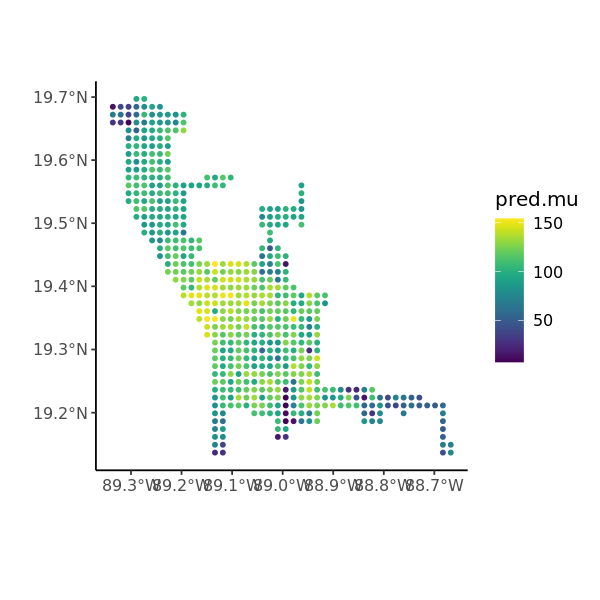

[1] "Deforestation ID:1 - Mean predicted AGBD: 102.01Mg/ha"
[1] "Deforestation ID:1 - Predicted SD of AGBD: 6.87Mg/ha"


Saving 6.67 x 6.67 in image


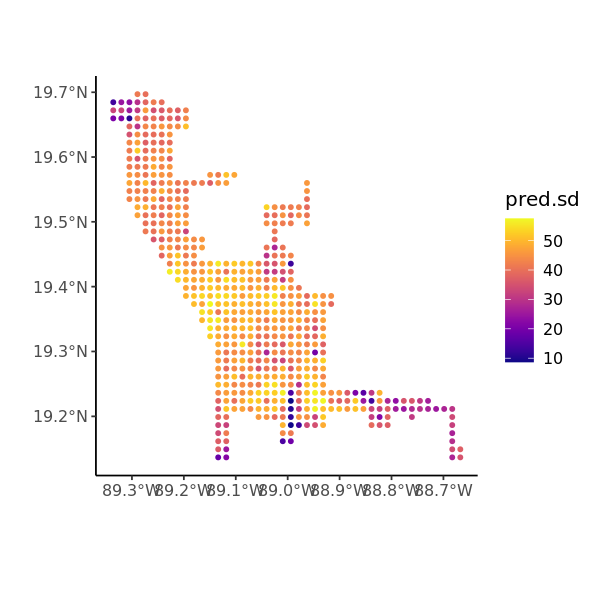

Saving 6.67 x 6.67 in image


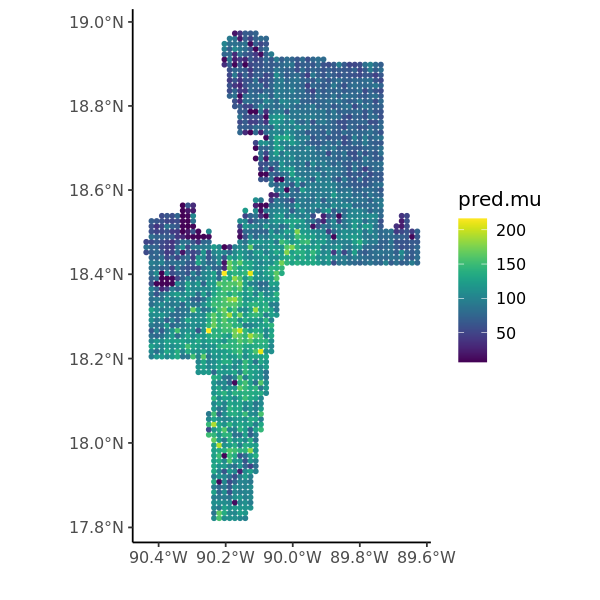

[1] "Deforestation ID:2 - Mean predicted AGBD: 92.94Mg/ha"
[1] "Deforestation ID:2 - Predicted SD of AGBD: 4.68Mg/ha"


Saving 6.67 x 6.67 in image


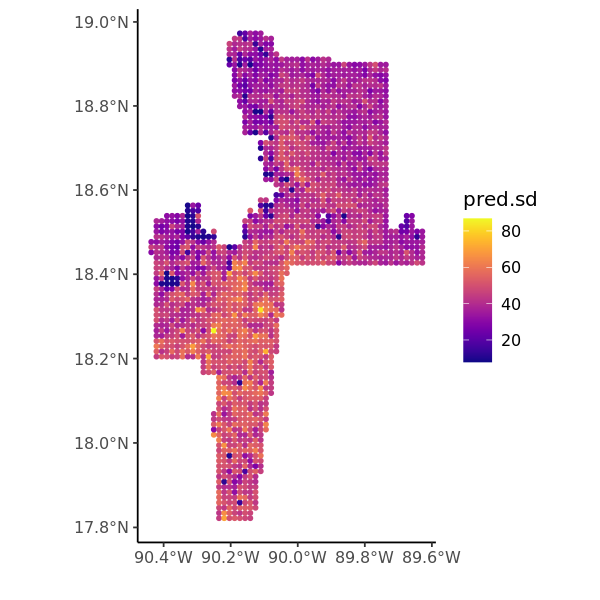

Saving 6.67 x 6.67 in image


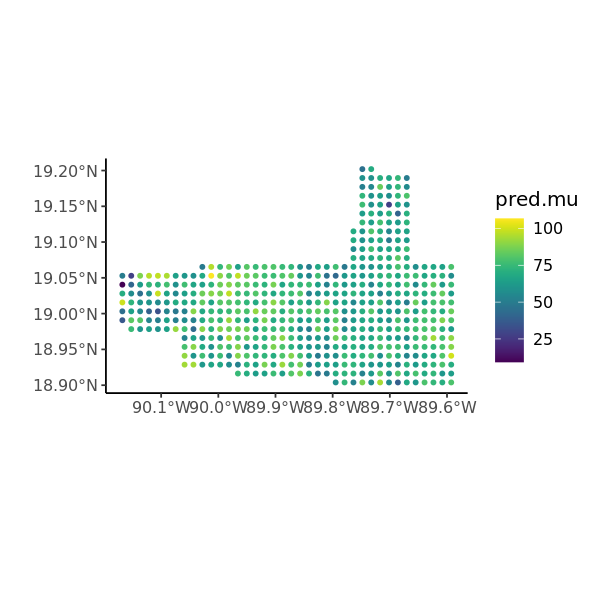

[1] "Deforestation ID:3 - Mean predicted AGBD: 69.64Mg/ha"
[1] "Deforestation ID:3 - Predicted SD of AGBD: 7.99Mg/ha"


Saving 6.67 x 6.67 in image


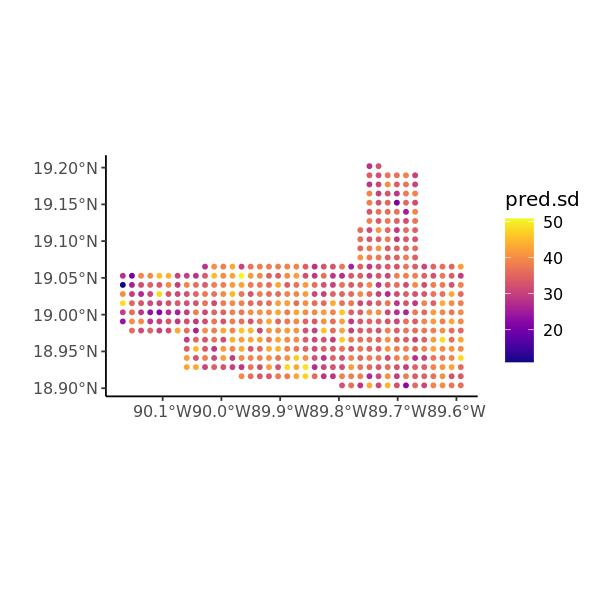

Saving 6.67 x 6.67 in image


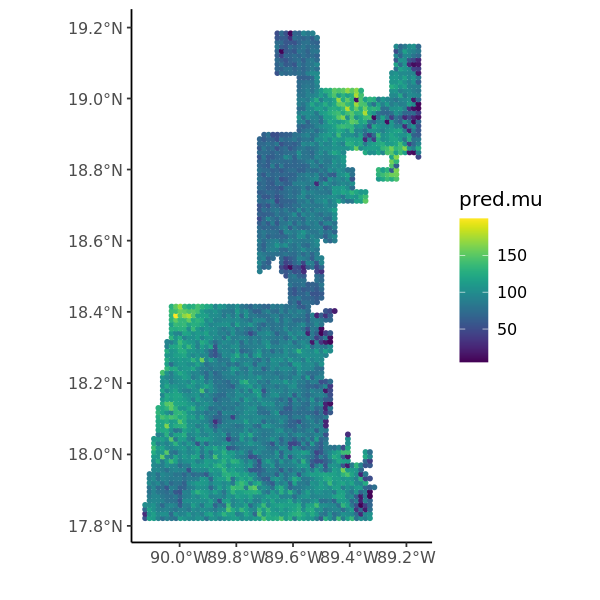

[1] "Deforestation ID:4 - Mean predicted AGBD: 91.85Mg/ha"
[1] "Deforestation ID:4 - Predicted SD of AGBD: 5.38Mg/ha"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


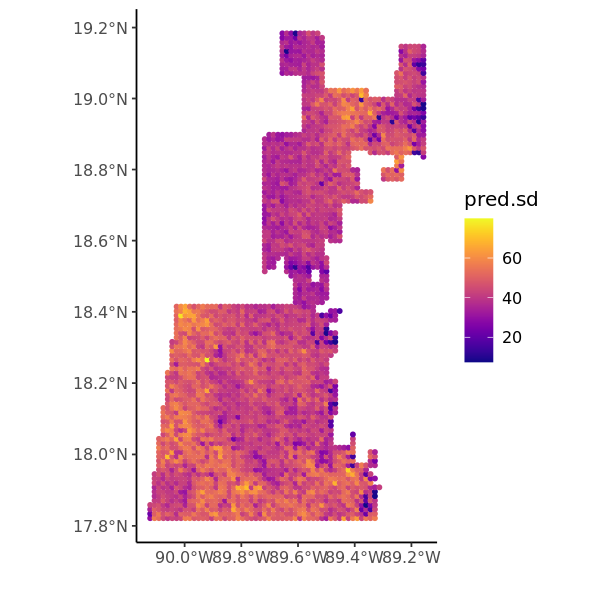

Saving 6.67 x 6.67 in image
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


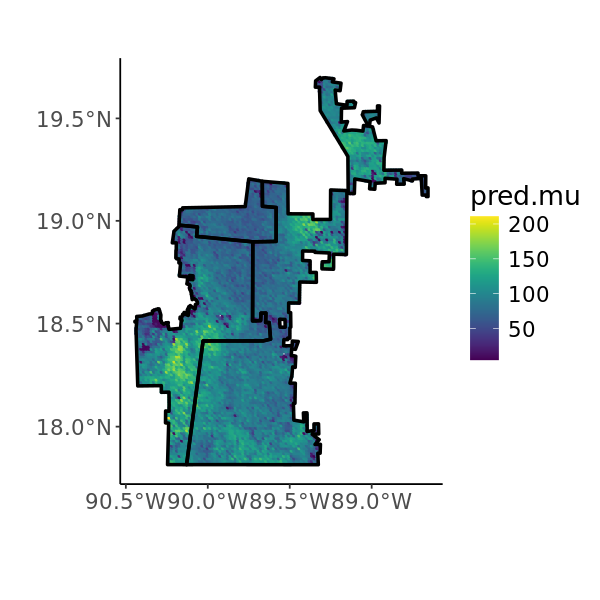

Saving 6.67 x 6.67 in image


[1] "Deforestation ID:4 - Mean predicted AGBD: 91.16Mg/ha"
[1] "Deforestation ID:4 - Predicted SD of AGBD: 3.7Mg/ha"


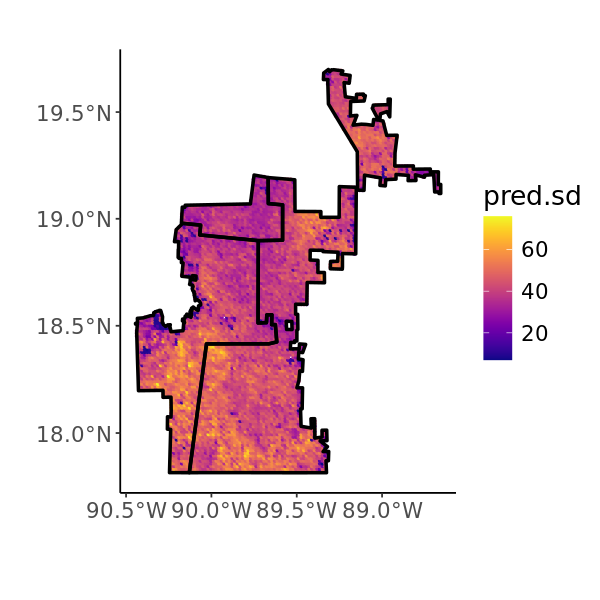

In [123]:
############## PREDICT AGBD IN NATURAL PROTECTED AREAS OF YUCATAN ############

# And this is where the notebook finally gets interesting! Imagine if we had a patch of land where we are interested in predicting AGBD. 
# How do we apply our model to the entire area covered by this land to predict mean AGBD and its associated SD? 
# We do this by selecting multiple locations inside the patch of land. The locations must be at least 56.42 x 2 m apart, which is the size of our NFI plot. 
# Then, we predict AGBD at all those locations (just like we did in the cells above). As a result, we will have multiple predictions of mean AGBD. 
# Finally, we simply take the mean of these mean AGBD values, and their standard deviation. 

# For simplicity, we have created two polygons of (hypothetically) disturbed forest. We loop through these to predict AGBD in each in a for loop. 

options(repr.plot.width=5, repr.plot.height=5)

cci.rast = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/cci_mexico_6933.tif")
hei.rast = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/GLAD_FH_mexico_UINT16_C_6399.tif")
samples = inla.posterior.sample(n = 250, result = model_fit_v2) # draw samples from our posterior distribution

Deforestation = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/PA_selected_v2.gpkg", quiet = TRUE) %>% st_transform(crs = 6933)  # Regions of deforestation.  
Deforestation <- st_difference(Deforestation, URBAN) # Remove urban areas by cutting them out from the shapefile 

for (f in (1:nrow(Deforestation))) {
    
    Deforestation_ID = f
    
    # Create a 120 x 120 m grid inside our patch of land, because we will predict AGBD at each grid center!
    grid_to_predict = st_make_grid(Deforestation[f,], cellsize = c(1500,1500), what = "centers") %>% st_as_sf() %>% st_filter(Deforestation[f,]) 
    grid_to_predict = grid_to_predict[URBAN, ,op=st_disjoint] # remove grid points that overlap with urban mask
    if (nrow(grid_to_predict[URBAN, ,op=st_disjoint])>0){
        grid = grid_to_predict %>% st_coordinates()

        # We'll need our covariate values at the grid locations
        cci.pred = extract(cci.rast, grid)[,1]
        hei.pred = extract(hei.rast, grid)[,1]

        A.pred = inla.spde.make.A(mesh = mesh, loc = grid) # remake our projector matrix for the grid centers
        pred_fun = function(...){
          drop(intercept + 
            cci.pred*cci + 
            hei.pred*hei +
            A.pred%*%alpha.spat[1:k] +   
            Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k] +
            Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:k]) +
            rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
        }

        # Generate prediction samples
        pred.samples = (inla.posterior.sample.eval(fun = pred_fun, samples = samples))
        pred.samples[pred.samples < 0] = 0

        # Model expectations and SD's at the grid locations
        pred.mu = Matrix::rowMeans(pred.samples^2, na.rm = T) # Mean AGBD values at each grid center
        pred.sd = apply(pred.samples^2, 1, sd) # SD of AGBD at each grid center

        p <- ggplot() + coord_sf(crs = 6933) + 
             geom_point(aes(x = grid[,1], y = grid[,2], col=pred.mu), size = 1) + # make a map to see plot locations and the predicted AGBD values at each location
             scale_color_viridis() + xlab("") + ylab("") + theme(text = element_text(size = 12),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
                   # scale_color_viridis() + ggtitle(paste0("GMB-predicted AGBD in ID: ",Deforestation_ID)) + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) + xlab("") + ylab("")
        print(p)
        ggsave(paste0("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/PA_",Deforestation_ID,"_MEAN.png"),plot = last_plot(),scale = 1,dpi = 400)
        
        p <- ggplot() + coord_sf(crs = 6933) + 
             geom_point(aes(x = grid[,1], y = grid[,2], col=pred.sd), size = 1) + # make a map to see plot locations and the predicted AGBD values at each location
             scale_color_viridis(option="plasma") + xlab("") + ylab("") + theme(text = element_text(size = 12),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
           # scale_color_viridis() + ggtitle(paste0("GMB-predicted AGBD in ID: ",Deforestation_ID)) + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) + xlab("") + ylab("")
        print(p)
        ggsave(paste0("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/PA_",Deforestation_ID,"_SD.png"),plot = last_plot(),scale = 1,dpi = 400)

        print(paste0("Deforestation ID:",Deforestation_ID," - Mean predicted AGBD: ", round(mean(pred.mu,na.rm=TRUE),digits=2) ,"Mg/ha"))
        print(paste0("Deforestation ID:",Deforestation_ID," - Predicted SD of AGBD: ", round(sd(colMeans(pred.samples^2, na.rm = T),na.rm=TRUE),digits=2) ,"Mg/ha"))
    } else {
        print(paste0("Deforestation ID:",Deforestation_ID," is entirely an urban area"))
    }
}

################ FIGURE FOR THE PAPER #####################
Deforestation = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/PA_selected_v2.gpkg", quiet = TRUE) %>% st_union() %>% st_transform(crs = 6933)  # Regions of deforestation.  
grid_to_predict = st_make_grid(Deforestation, cellsize = c(1500,1500), what = "centers") %>% st_as_sf() %>% st_filter(Deforestation) 
grid_to_predict = grid_to_predict[URBAN, ,op=st_disjoint] # remove grid points that overlap with urban mask
grid = grid_to_predict %>% st_coordinates()
cci.pred = extract(cci.rast, grid)[,1]
hei.pred = extract(hei.rast, grid)[,1]

A.pred = inla.spde.make.A(mesh = mesh, loc = grid) # remake our projector matrix for the grid centers
pred_fun = function(...){
  drop(intercept + 
    cci.pred*cci + 
    hei.pred*hei +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k] +
    Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:k]) +
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

pred.samples = (inla.posterior.sample.eval(fun = pred_fun, samples = samples))
pred.samples[pred.samples < 0] = 0
pred.mu = Matrix::rowMeans(pred.samples^2, na.rm = T) # Mean AGBD values at each grid center
pred.sd = apply(pred.samples^2, 1, sd) # SD of AGBD at each grid center

Deforestation = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/PA_selected_v2.gpkg", quiet = TRUE) %>% st_transform(crs = 6933)  # Regions of deforestation.  

p <- ggplot() + coord_sf(crs = 6933) + 
     geom_point(aes(x = grid[,1], y = grid[,2], col=pred.mu), size = 0.5) + # make a map to see plot locations and the predicted AGBD values at each location
     geom_sf(data = Deforestation,col="black",fill=NA,lwd=1) + # add our fake deforestation sites 
     scale_color_viridis() + xlab("") + ylab("") + theme(text = element_text(size = 16),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
print(p)
ggsave(paste0("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/PA_","ALL","_MEAN.png"),plot = last_plot(),scale = 1,dpi = 400)

p <- ggplot() + coord_sf(crs = 6933) + 
     geom_point(aes(x = grid[,1], y = grid[,2], col=pred.sd), size = 0.5) + # make a map to see plot locations and the predicted AGBD values at each location
     geom_sf(data = Deforestation,col="black",fill=NA,lwd=1) + # add our fake deforestation sites      
     scale_color_viridis(option="plasma") + xlab("") + ylab("") + theme(text = element_text(size = 16),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))
print(p)
ggsave(paste0("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/PA_","ALL","_SD.png"),plot = last_plot(),scale = 1,dpi = 400)

print(paste0("Deforestation ID:",Deforestation_ID," - Mean predicted AGBD: ", round(mean(pred.mu,na.rm=TRUE),digits=2) ,"Mg/ha"))
print(paste0("Deforestation ID:",Deforestation_ID," - Predicted SD of AGBD: ", round(sd(colMeans(pred.samples^2, na.rm = T),na.rm=TRUE),digits=2) ,"Mg/ha"))

In [ ]:
############## PREDICT AGBD IN ALL NATURAL PROTECTED AREAS ############

options(repr.plot.width=5, repr.plot.height=5)

cci.rast = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/cci_mexico_6933.tif")
hei.rast = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/GLAD_FH_mexico_UINT16_C_6399.tif")
samples = inla.posterior.sample(n = 250, result = model_fit_v2) # draw samples from our posterior distribution

Deforestation = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/anpmx.gpkg", quiet = TRUE) %>% st_transform(crs = 6933)  # Regions of deforestation.  
Deforestation <- st_difference(Deforestation, URBAN) # Remove urban areas by cutting them out from the shapefile 
NPA_GMBpredictions <- Deforestation
NPA_GMBpredictions['GMB_mean_AGBD_dense'] <- NA
NPA_GMBpredictions['GMB_sd_AGBD_dense'] <- NA

for (f in (1:nrow(Deforestation))) {
    
    Deforestation_ID = f
    ID_ANP <- Deforestation[f,]$ID_ANP
    print(ID_ANP)
    
    if (Deforestation[f,]$S_MARINA == 0) {
    
        # Create a 120 x 120 m grid inside our patch of land, because we will predict AGBD at each grid center!
        grid_to_predict = st_make_grid(Deforestation[f,], cellsize = c(1500,1500), what = "centers") %>% st_as_sf() %>% st_filter(Deforestation[f,]) 
        grid_to_predict = grid_to_predict[URBAN, ,op=st_disjoint] # remove grid points that overlap with urban mask
        if (nrow(grid_to_predict[URBAN, ,op=st_disjoint])>0){
            grid = grid_to_predict %>% st_coordinates()

            # We'll need our covariate values at the grid locations
            cci.pred = extract(cci.rast, grid)[,1]
            hei.pred = extract(hei.rast, grid)[,1]

            A.pred = inla.spde.make.A(mesh = mesh, loc = grid) # remake our projector matrix for the grid centers
            pred_fun = function(...){
              drop(intercept + 
                cci.pred*cci + 
                hei.pred*hei +
                A.pred%*%alpha.spat[1:k] +   
                Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k] +
                Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:k]) +
                rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
            }

            # Generate prediction samples
            pred.samples = (inla.posterior.sample.eval(fun = pred_fun, samples = samples))
            pred.samples[pred.samples < 0] = 0

            # Model expectations and SD's at the grid locations
            pred.mu = Matrix::rowMeans(pred.samples^2, na.rm = T) # Mean AGBD values at each grid center
            pred.sd = apply(pred.samples^2, 1, sd) # SD of AGBD at each grid center

            NPA_GMBpredictions[f,]$GMB_mean_AGBD_dense <- round(mean(pred.mu,na.rm=TRUE),digits=2)
            NPA_GMBpredictions[f,]$GMB_sd_AGBD_dense <- round(sd(colMeans(pred.samples^2, na.rm = T),na.rm=TRUE),digits=2)

            print(paste0("Deforestation ID:",Deforestation_ID," - Mean predicted AGBD: ", round(mean(pred.mu,na.rm=TRUE),digits=2) ,"Mg/ha"))
            print(paste0("Deforestation ID:",Deforestation_ID," - Predicted SD of AGBD: ", round(sd(colMeans(pred.samples^2, na.rm = T),na.rm=TRUE),digits=2) ,"Mg/ha"))
        } else {
            print(paste0("Deforestation ID:",Deforestation_ID," is entirely an urban area"))
        }
    }
}
st_write(NPA_GMBpredictions, dsn = file.path('/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/NPA_GMBpredictions.gpkg'), layer = 'NPA_GMBpredictions', quiet = TRUE)

In [32]:
#################### LETS TRY TO PREDICT AGBD IN ALL PROJECT AREAS IN MEXICO ######

## This section is essentially a replica of the previous, but moved to AWS batch processing to enable efficient processing
## of >180,000 project areas. 

PROJECTS = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/11_Merge_PSAyMFCcCyPM_Dummies_Rdo.gpkg", quiet = TRUE) %>% st_transform(crs = 6933)
PROJECTS$ID <- seq.int(nrow(PROJECTS))
PROJECTS$DPS_ID <- PROJECTS$ID
PROJECTS$GMB_mean_AGBD_dense = NA
PROJECTS$GMB_sd_AGBD_dense = NA
PROJECTS$GMB_mean_AGBD_FOREST = NA
PROJECTS$GMB_sd_AGBD_FOREST = NA

PROJECTS$GROUP <- ceiling(seq_along(PROJECTS$ID)/1000)
for (each_group in unique(PROJECTS$GROUP)){
    PROJECTS_SPLIT <- PROJECTS[PROJECTS$GROUP == each_group,]
    st_write(PROJECTS_SPLIT, dsn = file.path(paste0('/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/11_Merge_PSAyMFCcCyPM_Dummies_Rdo_SPLIT/PROJECTS_',as.character(each_group),'.gpkg')), layer = paste0('PROJECTS_',as.character(each_group)), overwrite=TRUE, quiet = TRUE)
    date_time<-Sys.time()
    while((as.numeric(Sys.time()) - as.numeric(date_time))<2.5){}
}

### AFTER THIS POINT, PROCESSING IS MOVED TO AWS FOR FAST EXECUTION 
### RESULTS ARE SUMMARIZED BELOW

Predictions <- list.files(path = "/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/11_Merge_PSAyMFCcCyPM_Dummies_Rdo_PREDICTIONS/", pattern = c("GMB_predictions.csv"),full.names = TRUE)

for (n in 1:length(Predictions)) {
    Data <- read.csv(Predictions[n])
    if (n==1){PREDS <- Data}
    if (n>1){PREDS <- rbind(PREDS,Data)}
}

write.csv(PREDS,"/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/11_Merge_PSAyMFCcCyPM_Dummies_Rdo_PREDICTIONS/PROJECTS_ALL_predictions.csv",row.names=FALSE) #Save the data

PREDS_GPKG <- merge(x= PROJECTS, y=PREDS, by=c('DPS_ID'), all=TRUE) 
st_write(PREDS_GPKG, dsn='/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/11_Merge_PSAyMFCcCyPM_Dummies_Rdo_GMBpredictions.gpkg', layer = '11_Merge_PSAyMFCcCyPM_Dummies_Rdo_GMBpredictions', overwrite=TRUE, quiet = TRUE)
##########################

Cannot preload entire working area of 9385516650 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 742422165 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


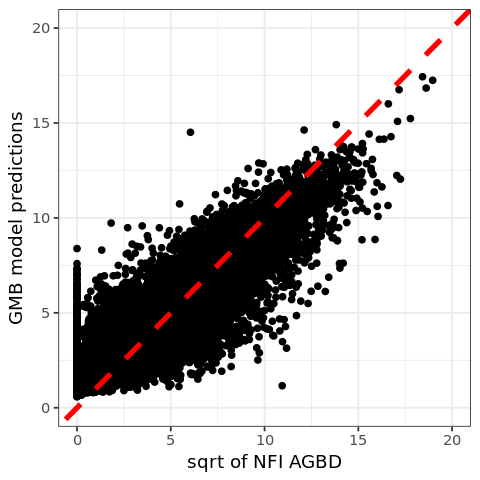

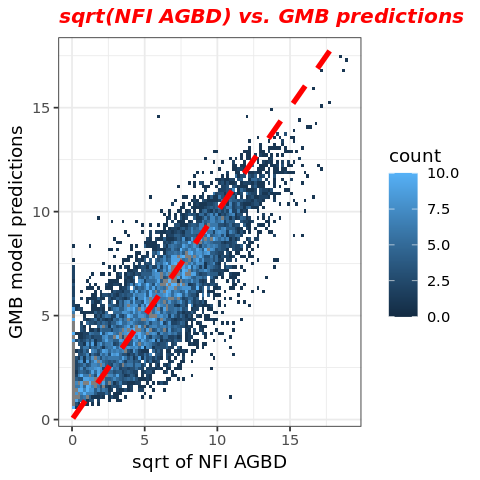

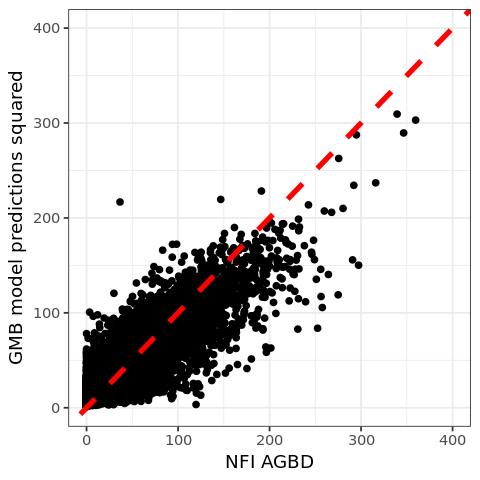

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


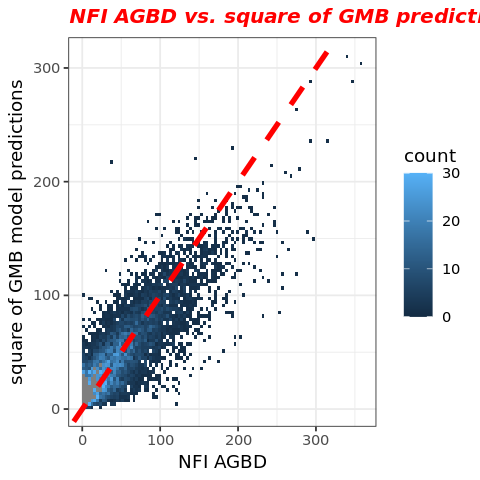

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


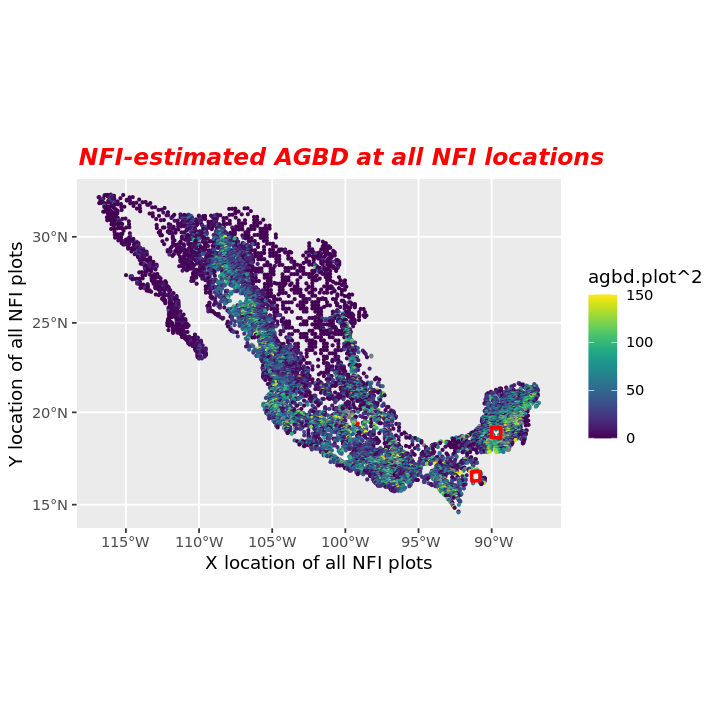

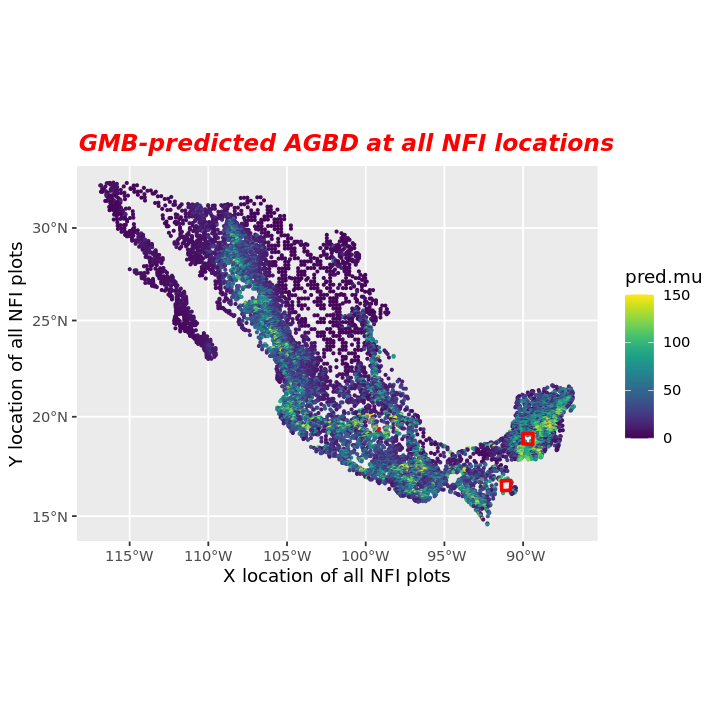

In [35]:
########################## CHECK HOW OUR MODEL PERFORMS AT ALL NFI LOCATIONS (TESTING AND TRAINING BOTH) ##################
options(repr.plot.width=4, repr.plot.height=4)

# Just to get a complete picture, we revert back to our whole dataset (including the 90% training and 10% testing data) and predict AGBD. 

plot_WGS84 <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/Daso_A_Cgl_C3_V7_24052022_1.gpkg", quiet = TRUE)
loc.plot.WGS84 <- st_coordinates(plot_WGS84)  ### get the plot locations in WGS84
plot = plot_WGS84 %>% st_transform("epsg:6933") ### convert them to a projected CRS
agbd.plot = sqrt(plot$AGB_C3) ### get the AGBD estimate at each plot location and square root it
loc.plot = st_coordinates(plot) ### save the plot location xy coordinates in projected CRS

hei.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/GLAD_FH_mexico_UINT16_C_6399.tif")### Read GLAD FOREST HEIGHT raster, already in projected CRS
hei.pred = exactextractr::exact_extract(hei.rast, st_buffer(plot,56.42), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel

cci.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/cci_mexico_6933.tif") ### Read CCI raster, already in projected CRS
cci.pred = exactextractr::exact_extract(cci.rast, st_buffer(plot,56.42), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel

samples = inla.posterior.sample(n = 250, result = model_fit_v2)
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot) 

# # Our prediction equation. 
pred_fun = function(...){
  drop(intercept + 
    cci.pred*cci + 
    hei.pred*hei +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k] +
    Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples. Using the 250 drawn samples, we make 250 predictions of AGBD at each location. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples))
pred.samples[pred.samples < 0] = 0

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=agbd.plot, PRED.SD=pred.sd, RES=agbd.plot-pred.mu))
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point() + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,20) + ylim(0,20) + xlab("sqrt of NFI AGBD") + ylab("GMB model predictions")

ggplot(data = OUTPUT, aes(x = NFI,y = PRED)) +
  geom_bin2d(bins = 100) + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) +
  scale_fill_gradient(limits = c(0, 10)) + xlab("sqrt of NFI AGBD") + ylab("GMB model predictions") + ggtitle("sqrt(NFI AGBD) vs. GMB predictions") +
  theme_bw() + theme(plot.title = element_text(color="red", size=12, face="bold.italic"))

# Let's also square the model expectations because we applied a sqrt transformation at the start
pred.mu = Matrix::rowMeans(pred.samples^2)
pred.sd = apply(pred.samples^2, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=agbd.plot^2, PRED.SD=pred.sd, RES=agbd.plot^2-pred.mu))
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,400) + ylim(0,400) + xlab("NFI AGBD") + ylab("GMB model predictions squared")

ggplot(data = OUTPUT, aes(x = NFI,y = PRED)) +
  geom_bin2d(bins = 100) + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) +
  scale_fill_gradient(limits = c(0, 30)) + xlab("NFI AGBD") + ylab("square of GMB model predictions") + ggtitle("NFI AGBD vs. square of GMB predictions") +
  theme_bw() + theme(plot.title = element_text(color="red", size=12, face="bold.italic"))

####################### And here are some maps to see what the results look like ##########
options(repr.plot.width=6, repr.plot.height=6)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot[,1], y = loc.plot[,2], col = agbd.plot^2),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 150)) + xlab("X location of all NFI plots") + ylab("Y location of all NFI plots") + ggtitle("NFI-estimated AGBD at all NFI locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) 

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot[,1], y = loc.plot[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 150)) + xlab("X location of all NFI plots") + ylab("Y location of all NFI plots") + ggtitle("GMB-predicted AGBD at all NFI locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) 

######## Save the pred.samples output, because the predictions per column will be needed for stratum-wise or a country-wide AGBD SD estimate ############
NFI.pred.samples = cbind(pred.samples^2,loc.plot[,1],loc.plot[,2])